# 2020 Dask User Survey Results

This notebook presents the results of the 2020 Dask User Survey,
which ran earlier this summer. Thanks to everyone who took the time to fill out the survey!
These results help us better understand the Dask community and will guide future development efforts.

The raw data, as well as the start of an analysis, can be found in this binder:

[![2020 Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/dask/dask-examples/main?urlpath=%2Ftree%2Fsurveys%2F2020.ipynb)

Let us know if you find anything in the data.

## Highlights

We had 240 responses to the survey (slightly fewer than last year, which had about 260). Overall things were similar to last year's. The biggest shift in the community is a stronger demand for better performance.

In [1]:
%matplotlib inline

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import textwrap
import re


df2019 = (
    pd.read_csv("data/2019-user-survey-results.csv.gz", parse_dates=["Timestamp"])
      .replace({"How often do you use Dask?": "I use Dask all the time, even when I sleep"}, "Every day")
)

df2020 = (
    pd.read_csv("data/2020-user-survey-results.csv.gz")
      .assign(Timestamp=lambda df: pd.to_datetime(df['Timestamp'], format="%Y/%m/%d %H:%M:%S %p %Z").astype('datetime64[ns]'))
      .replace({"How often do you use Dask?": "I use Dask all the time, even when I sleep"}, "Every day")
)
df2020.head()

common = df2019.columns & df2020.columns
added = df2020.columns.difference(df2019.columns)
dropped = df2019.columns.difference(df2020.columns)

df = pd.concat([df2019, df2020])
df['Year'] = df.Timestamp.dt.year
df = df.set_index(['Year', 'Timestamp']).sort_index()

/tmp/ipykernel_10445/4082487205.py:17: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  .assign(Timestamp=lambda df: pd.to_datetime(df['Timestamp'], format="%Y/%m/%d %H:%M:%S %p %Z").astype('datetime64[ns]'))
/tmp/ipykernel_10445/4082487205.py:22: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead.
  common = df2019.columns & df2020.columns


Most of the questions are the same as in 2019. We added a couple questions about deployment and dashboard usage. Let's look at those first.

Among respondents who use a Dask package to deploy a cluster (about 53% of respondents), there's a wide spread of methods.

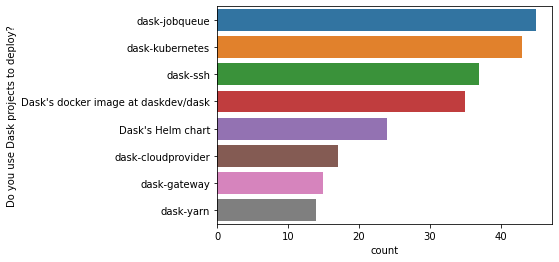

In [2]:
k = 'Do you use Dask projects to deploy?'
d = df2020['Do you use Dask projects to deploy?'].dropna().str.split(";").explode()
top = d.value_counts()
top = top[top > 10].index
sns.countplot(y=k, data=d[d.isin(top)].to_frame(), order=top);

Most people access the dashboard through a web browser. Those not using the dashboard are likely (hopefully) just using Dask on a single machine with the threaded scheduler (though the dashboard works fine on a single machine as well).

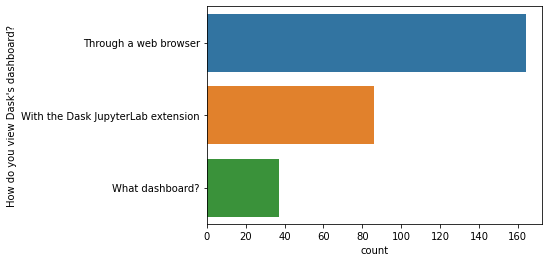

In [3]:
k = "How do you view Dask's dashboard?"
sns.countplot(y=k, data=df2020[k].dropna().str.split(";").explode().to_frame());

Dask's learning materials are farily similar to last year. The most notable differences are from
our survey form providing more options (our [YouTube channel](https://www.youtube.com/channel/UCj9eavqmvwaCyKhIlu2GaoA) and "Gitter chat"). Other than that, https://examples.dask.org might be relatively more popular.

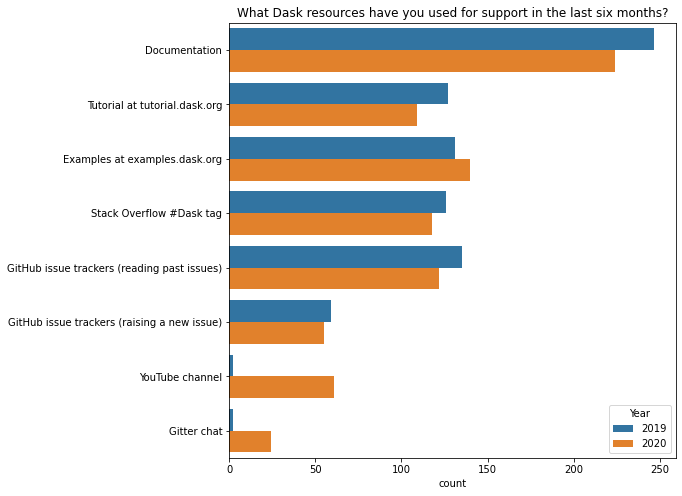

In [4]:
k = 'What Dask resources have you used for support in the last six months?'

resource_map = {
    "Tutorial": "Tutorial at tutorial.dask.org",
    "YouTube": "YouTube channel",
    "gitter": "Gitter chat"
}

d = df[k].str.split(';').explode().replace(resource_map)
top = d.value_counts()[:8].index
d = d[d.isin(top)]

fig, ax = plt.subplots(figsize=(8, 8))
ax = sns.countplot(y=k, hue="Year", data=d.reset_index(), ax=ax);
ax.set(ylabel="", title=k);

## How do you use Dask?

Just like last year, we'll look at resource usage grouped by how often they use Dask.

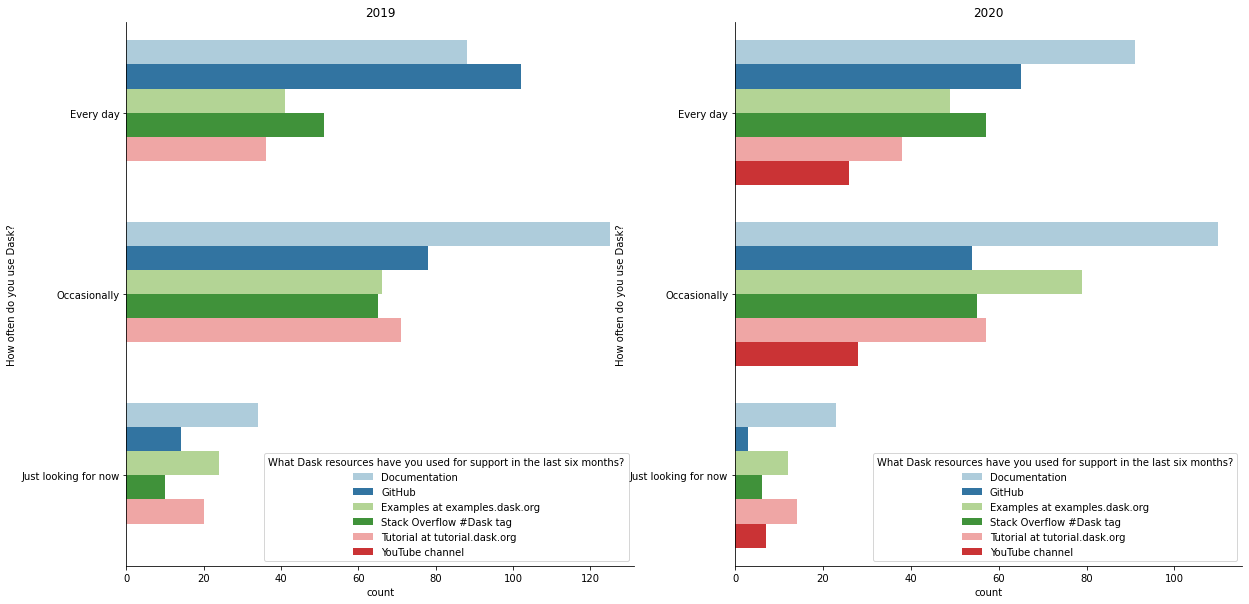

In [5]:
resource_palette = (
    df['What Dask resources have you used for support in the last six months?'].str.split(";").explode().replace(resource_map).replace(re.compile("GitHub.*"), "GitHub").value_counts()[:6].index
)
resource_palette = dict(zip(resource_palette, sns.color_palette("Paired")))

usage_order = ['Every day', 'Occasionally', 'Just looking for now']

def resource_plot(df, year, ax):
    resources = (
        df.loc[year, 'What Dask resources have you used for support in the last six months?']
          .str.split(";")
          .explode()
          .replace(resource_map)
    )
    top = resources.value_counts().head(6).index
    resources = resources[resources.isin(top)]

    m = (
        pd.merge(df.loc[year, ['How often do you use Dask?']], resources, left_index=True, right_index=True)
          .replace(re.compile("GitHub.*"), "GitHub")
    )

    ax = sns.countplot(hue="What Dask resources have you used for support in the last six months?",
                  y='How often do you use Dask?',
                  order=usage_order,
                  data=m, ax=ax,
                  hue_order=list(resource_palette),
                  palette=resource_palette)
    sns.despine()
    return ax

fig, axes = plt.subplots(figsize=(20, 10), ncols=2)
ax1 = resource_plot(df, 2019, axes[0])
ax2 = resource_plot(df, 2020, axes[1])
ax1.set_title("2019")
ax2.set_title("2020");

A few observations


* GitHub issues are becoming relatively less popular among moderate and heavy Dask users, which perhaps reflects better documentation or stability (assuming people go to the issue tracker when they can't find the answer in the docs or they hit a bug).
* https://examples.dask.org is notably now more popular among occasinal users.
* In response to last year's survey, we invested time in making https://tutorial.dask.org better, which we previously felt was lacking. Its usage is still about the same as last year's (pretty popular), so it's unclear whether we should dedicate additional focus there.

API usage remains about the same as last year (recall that about 20 fewer people took the survey and people can select multiple, so relative differences are most interesting). We added new choices for RAPIDS, Prefect, and XGBoost, each of which are somewhat popular (in the neighborhood of `dask.Bag`).

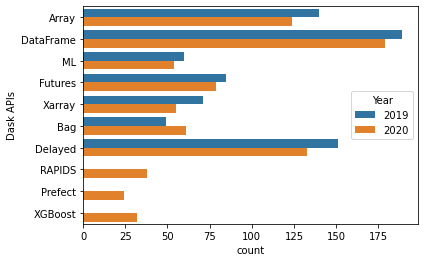

In [6]:
apis = df['Dask APIs'].str.split(";").explode()
top = apis.value_counts().loc[lambda x: x > 10]
apis = apis[apis.isin(top.index)].reset_index()

sns.countplot(y="Dask APIs", hue="Year", data=apis);

Just like last year, about 65% of our users are using Dask on a cluster at least some of the time.

In [7]:
df['Local machine or Cluster?'].dropna().str.contains("Cluster").astype(int).groupby("Year").mean()

Year
2019    0.654902
2020    0.666667
Name: Local machine or Cluster?, dtype: float64

But the majority of respondents *also* use Dask on their laptop.
This highlights the importance of Dask scaling down, either for
prototyping with a `LocalCluster`, or for out-of-core analysis
using `LocalCluster` or one of the single-machine schedulers.

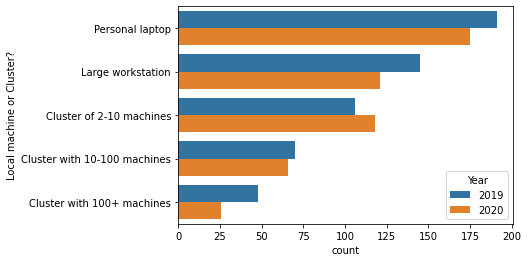

In [8]:
order = [
    'Personal laptop',
    'Large workstation',
    'Cluster of 2-10 machines',
    'Cluster with 10-100 machines',
    'Cluster with 100+ machines'
]
d = df['Local machine or Cluster?'].str.split(";").explode().reset_index()
sns.countplot(y="Local machine or Cluster?", data=d, hue="Year", order=order);

Just like last year, most repondents thought that more documentation and examples would be the most valuable improvements to the project.

One interesting change comes from looking at "Which would help you most right now?" split by API group (`dask.dataframe`, `dask.array`, etc.). Last year showed that "More examples" in my field was the most important for all API groups (first table below). But in 2020 there are some differences (second plot below).

In [9]:
help_by_api = (
    pd.merge(
        df.loc[2019, 'Dask APIs'].str.split(';').explode(),
        df.loc[2019, 'Which would help you most right now?'],
        left_index=True, right_index=True)
    .groupby('Which would help you most right now?')['Dask APIs'].value_counts()
    .unstack(fill_value=0).T
    .loc[['Array', 'Bag', 'DataFrame', 'Delayed', 'Futures', 'ML', 'Xarray']]
    
)
(
    help_by_api
        .style
        .background_gradient(axis="columns")
        .set_caption("2019 normalized by row. Darker means that a higher proporiton of "
                     "users of that API prefer that priority.")
)

Which would help you most right now?,Bug fixes,More documentation,More examples in my field,New features,Performance improvements
Dask APIs,,,,,
Array,10,24,62,15,25
Bag,3,11,16,10,7
DataFrame,16,32,71,39,26
Delayed,16,22,55,26,27
Futures,12,9,25,20,17
ML,5,11,23,11,7
Xarray,8,11,34,7,9


In [10]:
help_by_api = (
    pd.merge(
        df.loc[2020, 'Dask APIs'].str.split(';').explode(),
        df.loc[2020, 'Which would help you most right now?'],
        left_index=True, right_index=True)
    .groupby('Which would help you most right now?')['Dask APIs'].value_counts()
    .unstack(fill_value=0).T
    .loc[['Array', 'Bag', 'DataFrame', 'Delayed', 'Futures', 'ML', 'Xarray']]
    
)
(
    help_by_api
        .style
        .background_gradient(axis="columns")
        .set_caption("2020 normalized by row. Darker means that a higher proporiton of "
                     "users of that API prefer that priority.")
)

Which would help you most right now?,Bug fixes,More documentation,More examples in my field,New features,Performance improvements
Dask APIs,,,,,
Array,12,16,56,15,23
Bag,7,5,24,7,16
DataFrame,24,21,67,22,41
Delayed,15,19,46,17,34
Futures,9,10,21,13,24
ML,6,4,21,9,12
Xarray,3,4,25,9,13


Examples are again the most important (for all API groups except `Futures`). But "Performance improvements" is now the second-most important field (except for `Futures` where it's most important). How should we interpret this? A charitable interpretation is that Dask's users are scaling to larger problems and are running into new scaling challenges. A less charitable interpretation is that our user's workflows are the same but Dask is getting slower!

## Common Feature Requests

For specific features, we made a list of things that we (as developers) thought might be important.

/usr/share/miniconda3/envs/dask-examples/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


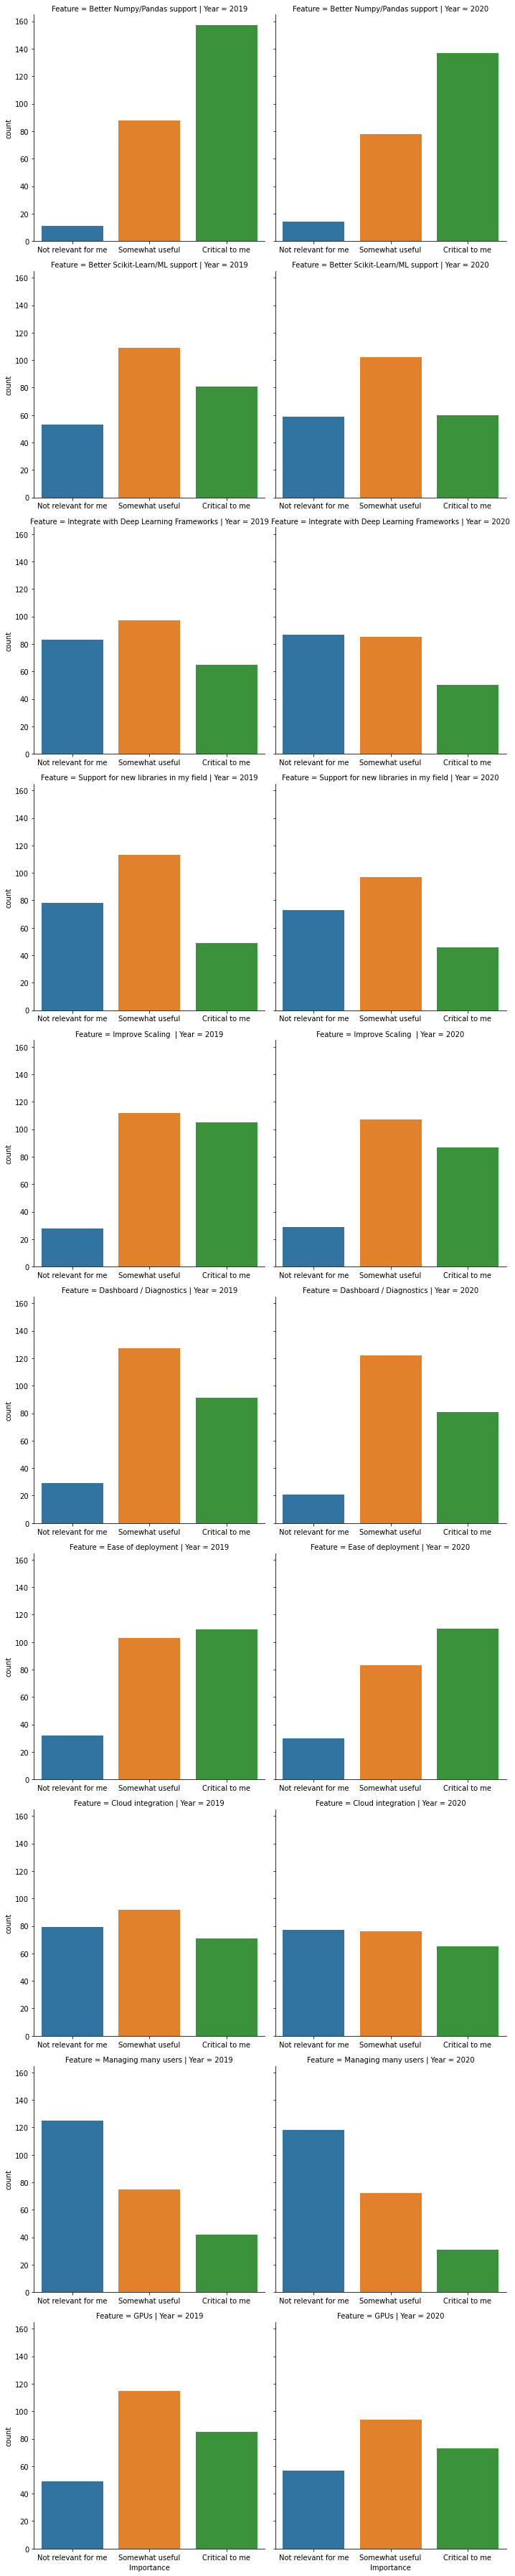

In [11]:
common = (df[df.columns[df.columns.str.startswith("What common feature")]]
          .rename(columns=lambda x: x.lstrip("What common feature requests do you care about most?[").rstrip(r"]")))
a = common.loc[2019].apply(pd.value_counts).T.stack().reset_index().rename(columns={'level_0': 'Question', 'level_1': "Importance", 0: "count"}).assign(Year=2019)
b = common.loc[2020].apply(pd.value_counts).T.stack().reset_index().rename(columns={'level_0': 'Question', 'level_1': "Importance", 0: "count"}).assign(Year=2020)

counts = pd.concat([a, b], ignore_index=True)

d = common.stack().reset_index().rename(columns={"level_2": "Feature", 0: "Importance"})
order = ["Not relevant for me", "Somewhat useful", 'Critical to me']
sns.catplot('Importance', row="Feature", kind="count", col="Year", data=d, sharex=False, order=order);

There really aren't any changes compared to last year in the relative importance of each feature. Perhaps the biggest movement was in "Ease of deployment" where "Critical to me" is now relatively more popular (though it was the most popular even last year).


## What other systems do you use?

SSH continues to be the most popular "cluster resource mananger". This was the big surprise last year, so we put in some work to make it nicer. Aside from that, not much has changed.

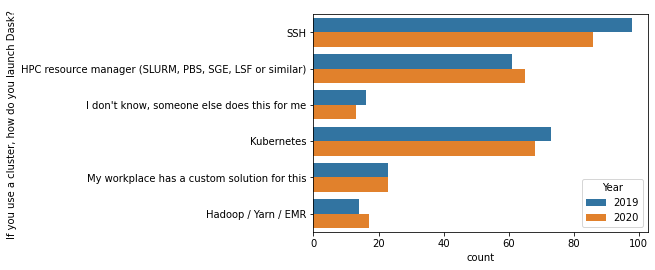

In [12]:
c = df['If you use a cluster, how do you launch Dask? '].dropna().str.split(";").explode()
top = c.value_counts().index[:6]
sns.countplot(y="If you use a cluster, how do you launch Dask? ", data=c[c.isin(top)].reset_index(), hue="Year");

Dask users are about as happy with its stability as last year.

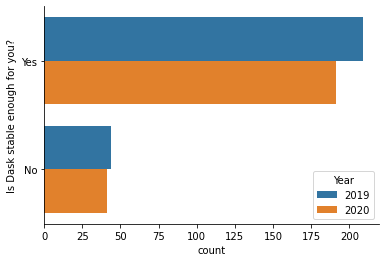

In [13]:
# fig, ax = plt.subplots(figsize=(9, 6))
sns.countplot(y="Is Dask stable enough for you?", hue="Year", data=df.reset_index())
sns.despine()

## Takeaways

1. Overall, most things are similar to last year.
2. Documentation, especially domain-specific examples, continues to be important.
3. More users are pushing Dask further. Investing in performance is likely to be valuable.

Thanks again to all the respondents. We look forward to repeating this process to identify trends over time.